Notebook is inspired by https://github.com/EmilienDupont/neural-processes/tree/master.

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [93]:
import numpy as np
import torch
from math import pi
from PIL import Image
from torchvision import datasets, transforms
from torch import nn
from torch.nn import functional as F
from torch.distributions import Normal
from random import randint
from torch.distributions.kl import kl_divergence
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from tqdm import tqdm
import torchvision
from IPython import display


# Data, preprocessing and utils

In [100]:
size = 28
num_channels = 1

In [101]:
path_to_data = 'mnist_data'

all_transforms = transforms.Compose([
    transforms.ToTensor()
    ])

train_data = datasets.MNIST(path_to_data, train=True, download=True,
                                transform=all_transforms)
test_data = datasets.MNIST(path_to_data, train=False,
                               transform=all_transforms)

In [102]:
batch_size = 1024

In [103]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

In [104]:
def random_context_target_mask(size, num_context, num_extra_target):
    measurements = np.random.choice(range(size * size),
                                    size=num_context + num_extra_target,
                                    replace=False)
    context_mask = torch.zeros(size, size).byte()
    target_mask = torch.zeros(size, size).byte()
    for i, m in enumerate(measurements):
        row = int(m / size)
        col = m % size
        target_mask[row, col] = 1
        if i < num_context:
            context_mask[row, col] = 1
    return context_mask, target_mask


def batch_context_target_mask(size, num_context, num_extra_target, batch_size):
    context_mask_batch = torch.zeros(batch_size, size, size, dtype=torch.uint8)
    target_mask_batch = torch.zeros(batch_size, size, size, dtype=torch.uint8)

    for i in range(batch_size):
        context_mask, target_mask = random_context_target_mask(size,
                                                               num_context,
                                                               num_extra_target)
        context_mask_batch[i] = context_mask
        target_mask_batch[i] = target_mask

    return context_mask_batch, target_mask_batch


def img_mask_to_np_input(img, mask, normalize=True):
    batch_size, num_channels, height, width = img.size()
    mask_img_size = mask.unsqueeze(1).repeat(1, num_channels, 1, 1)
    num_points = mask[0].nonzero().size(0)
    nonzero_idx = mask.nonzero()
    x = nonzero_idx[:, 1:].view(batch_size, num_points, 2).float()
    y = img[mask_img_size].view(batch_size, num_channels, num_points)
    y = y.permute(0, 2, 1)

    if normalize:
        x = (x - float(height) / 2) / (float(height) / 2)
        y -= 0.5

    return x, y


def xy_to_img(x, y, img_size):
    _, height, width = img_size
    batch_size, _, _ = x.size()
    # Unnormalize x and y
    x = x * float(height / 2) + float(height / 2)
    x = x.long()
    y += 0.5
    # Permute y so it matches order expected by image
    # (batch_size, num_points, num_channels) -> (batch_size, num_channels, num_points)
    y = y.permute(0, 2, 1)
    # Initialize empty image
    img = torch.zeros((batch_size,) + img_size)
    for i in range(batch_size):
        img[i, :, x[i, :, 0], x[i, :, 1]] = y[i, :, :]
    return img

def inpaint(model, img, context_mask, device):
    is_training = model.neural_process.training
    # For inpainting, use Neural Process in prediction mode
    model.neural_process.training = False
    target_mask = 1 - context_mask  # All pixels which are not in context
    # Add a batch dimension to tensors and move to GPU
    img_batch = img.unsqueeze(0).to(device)
    context_batch = context_mask.unsqueeze(0).to(device)
    target_batch = target_mask.unsqueeze(0).to(device)
    p_y_pred = model(img_batch, context_batch, target_batch)
    # Transform Neural Process output back to image
    x_target, _ = img_mask_to_np_input(img_batch, target_batch)
    # Use the mean (i.e. loc) parameter of normal distribution as predictions
    # for y_target
    img_rec = xy_to_img(x_target.cpu(), p_y_pred.loc.detach().cpu(), img.size())
    img_rec = img_rec[0]  # Remove batch dimension
    # Add context points back to image
    context_mask_img = context_mask.unsqueeze(0).repeat(1, 1, 1)
    img_rec[context_mask_img] = img[context_mask_img]
    # Reset model to mode it was in before inpainting
    model.neural_process.training = is_training
    return img_rec

# Model

In this setting x is coordinated of pixel and y is its intensity. We will model it with Neural Process. Probabilistic model:

$$
p(z, y_{1:n}|x_{1:n}) = p(z) \prod_{i=1}^n 
        \mathcal{N}(y_i|g_{\theta}(x_i, z), \sigma^2)
$$


The model consist of several parts:

Encoder $h$ that takes pairs $(x, y)_i$ and maps them to representation $r_i$

Aggregator $a$ that summarizes inputs and is order-invariant. We need a single global representation $r = a(r_1, \ldots, r_n)$ to parameterize $z \sim \mathcal{N}(\mu(r), \sigma^2(r)I)$. Note linear complexity of aggregator in case $a(r_1, \ldots, r_n) = \sum_{i=1}^n r_i$

Conditional decoder $g$ that takes new points $x$ and the sampled latent variable $z$


<img src="/home/plahinal/club/model_graph.jpg" alt="Alternative text" />

In [105]:
class Encoder(nn.Module):
    def __init__(self, x_dim, y_dim, h_dim, r_dim):
        super(Encoder, self).__init__()

        self.x_dim = x_dim
        self.y_dim = y_dim
        self.h_dim = h_dim
        self.r_dim = r_dim
        # YOUR CODE GOES HERE: 3 LINEAR LAYERS WITH RELU
        layers = [...]

        self.input_to_hidden = ...

    def forward(self, x, y):
        # YOUR CODE GOES HERE
        pass


class MuSigmaEncoder(nn.Module):
    def __init__(self, r_dim, z_dim):
        super(MuSigmaEncoder, self).__init__()

        self.r_dim = r_dim
        self.z_dim = z_dim
        
        # YOUR CODE GOES HERE - ALL LAYERS ARE LINEAR

        self.r_to_hidden = ...
        self.hidden_to_mu = ...
        self.hidden_to_sigma = ...

    def forward(self, r):
        # YOUR CODE GOES HERE
        return mu, sigma


class Decoder(nn.Module):
    def __init__(self, x_dim, z_dim, h_dim, y_dim):
        super(Decoder, self).__init__()

        self.x_dim = x_dim
        self.z_dim = z_dim
        self.h_dim = h_dim
        self.y_dim = y_dim

        layers = [nn.Linear(x_dim + z_dim, h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(h_dim, h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(h_dim, h_dim),
                  nn.ReLU(inplace=True)]

        self.xz_to_hidden = nn.Sequential(*layers)
        self.hidden_to_mu = nn.Linear(h_dim, y_dim)
        self.hidden_to_sigma = nn.Linear(h_dim, y_dim)

    def forward(self, x, z):
        batch_size, num_points, _ = x.size()
        z = z.unsqueeze(1).repeat(1, num_points, 1)
        x_flat = x.view(batch_size * num_points, self.x_dim)
        z_flat = z.view(batch_size * num_points, self.z_dim)
        input_pairs = torch.cat((x_flat, z_flat), dim=1)
        hidden = self.xz_to_hidden(input_pairs)
        mu = self.hidden_to_mu(hidden)
        pre_sigma = self.hidden_to_sigma(hidden)
        mu = mu.view(batch_size, num_points, self.y_dim)
        pre_sigma = pre_sigma.view(batch_size, num_points, self.y_dim)
        sigma = 0.1 + 0.9 * F.softplus(pre_sigma)
        return mu, sigma

ELBO:

$$
\log p(y_{m+1:n}|x_{1:n}, y_{1:m}) \geq 
    \mathbb{E}_{q(z|x_{1:n}, y_{1:n})} \bigg[
    \sum_{i=m+1}^n \log p(y_i|z, x_i) + 
    \log \cfrac{q(z|x_{1:m}, y_{1:m})}{q(z|x_{1:n}, y_{1:n})} 
    \bigg]
$$

In [106]:
class NeuralProcess(nn.Module):
    def __init__(self, x_dim, y_dim, r_dim, z_dim, h_dim):
        super(NeuralProcess, self).__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.r_dim = r_dim
        self.z_dim = z_dim
        self.h_dim = h_dim

        self.xy_to_r = Encoder(x_dim, y_dim, h_dim, r_dim)
        self.r_to_mu_sigma = MuSigmaEncoder(r_dim, z_dim)
        self.xz_to_y = Decoder(x_dim, z_dim, h_dim, y_dim)

    def aggregate(self, r_i):
        return torch.mean(r_i, dim=1)

    def xy_to_mu_sigma(self, x, y):
        batch_size, num_points, _ = x.size()
        x_flat = x.view(batch_size * num_points, self.x_dim)
        y_flat = y.contiguous().view(batch_size * num_points, self.y_dim)
        r_i_flat = self.xy_to_r(x_flat, y_flat)
        r_i = r_i_flat.view(batch_size, num_points, self.r_dim)
        r = self.aggregate(r_i)
        return self.r_to_mu_sigma(r)

    def forward(self, x_context, y_context, x_target, y_target=None):
        if self.training:
            # YOUR CODE GOES HERE
            return p_y_pred, q_target, q_context
        else:
            # YOUR CODE GOES HERE
            return p_y_pred


class NeuralProcessImg(nn.Module):
    def __init__(self, img_size, r_dim, z_dim, h_dim):
        super(NeuralProcessImg, self).__init__()
        self.img_size = img_size
        self.num_channels, self.height, self.width = img_size
        self.r_dim = r_dim
        self.z_dim = z_dim
        self.h_dim = h_dim

        self.neural_process = NeuralProcess(x_dim=2, y_dim=self.num_channels,
                                            r_dim=r_dim, z_dim=z_dim,
                                            h_dim=h_dim)

    def forward(self, img, context_mask, target_mask):
        x_context, y_context = img_mask_to_np_input(img, context_mask)
        x_target, y_target = img_mask_to_np_input(img, target_mask)
        return self.neural_process(x_context, y_context, x_target, y_target)

In [107]:
def compute_loss(p_y_pred, y_target, q_target, q_context):
      # YOUR CODE GOES HERE
      pass

In [43]:
device='cuda'

In [60]:
neural_process = NeuralProcessImg([1, 28, 28], 256, 256, 256).to(device)
optimizer = torch.optim.Adam(neural_process.parameters(), lr=3e-5)

In [50]:
n_epochs = 25
step = 0
print_freq = 10
epoch_loss_history = []

In [ ]:
for epoch in range(n_epochs):
    epoch_loss = 0.
    for i, data in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()

        num_context = randint(*[3, 200])
        num_extra_target = randint(*[0, 200])

        img, _ = data
        batch_size = img.size(0)
        context_mask, target_mask = \
            batch_context_target_mask(size,
                                      num_context, num_extra_target,
                                      batch_size)

        img = img.to(device)
        context_mask = context_mask.to(device)
        target_mask = target_mask.to(device)

        p_y_pred, q_target, q_context = \
                  neural_process(img, context_mask, target_mask)

        _, y_target = img_mask_to_np_input(img, target_mask)

        loss = compute_loss(p_y_pred, y_target, q_target, q_context)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        step += 1

        if step % print_freq == 0:
            print("iteration {}, loss {:.3f}".format(step, loss.item()))

    print("Epoch: {}, Avg_loss: {}".format(epoch, epoch_loss / len(train_loader)))
    epoch_loss_history.append(epoch_loss / len(train_loader))

In [62]:
#checkpoint = torch.load('/home/plahinal/club/ckpt/model.pt')
#neural_process.load_state_dict(checkpoint)

<All keys matched successfully>

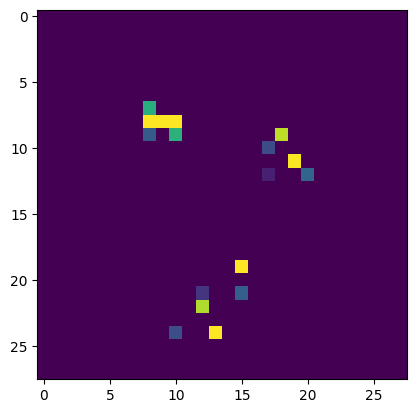

In [90]:
img = test_data[0]

context_mask = (torch.Tensor(28, 28).uniform_() > 0.9).byte()

occluded_img = img[0] * context_mask.float()
plt.imshow(occluded_img.permute(1, 2, 0).numpy())

/tmp/ipykernel_2989159/2818139484.py:36: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  y = img[mask_img_size].view(batch_size, num_channels, num_points)
/tmp/ipykernel_2989159/2818139484.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  img_rec[context_mask_img] = img[context_mask_img]


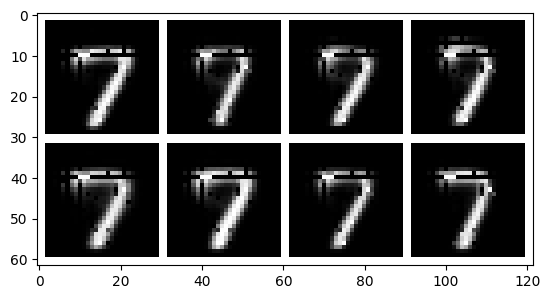

In [91]:
num_inpaintings = 8
all_inpaintings = torch.zeros(num_inpaintings, 1, 28, 28)

for i in range(num_inpaintings):
    all_inpaintings[i] = inpaint(neural_process, img[0], context_mask, device)

inpainting_grid = make_grid(all_inpaintings, nrow=4, pad_value=1.)
grid_as_np = inpainting_grid.permute(1, 2, 0).numpy()
plt.imshow(np.clip(grid_as_np, 0, 1))